In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import timeit
import ciw
import collections
import seaborn as sbr
import pandas as pd


# Define the model


![model](imgs/visualised_model.png)

In [2]:
def build_model(lambda_2, lambda_1, mu, total_capacity):
    """ Builds the required ciw network

    Parameters
    ----------
    lambda_2 : [float]
        [Arrival rate of ambulance patients]
    lambda_1 : [float]
        [Arrival rate of other patients]
    mu : [float]
        [Service rate of hospital]
    total_capacity : [integer]
        [The total capacity of the hospital]
    """
    model = ciw.create_network(
        arrival_distributions=[
            ciw.dists.Exponential(lambda_2),
            ciw.dists.Exponential(lambda_1),
        ],
        service_distributions=[ciw.dists.Deterministic(0), ciw.dists.Exponential(mu)],
        routing=[[0.0, 1.0], [0.0, 0.0]],
        number_of_servers=[float("inf"), total_capacity],
    )
    return model


# Inherit 'ciw.Node' class to block individuals of Node 1


![smart_model](imgs/visualised_smart_model.png)

In [3]:
def build_custom_node(threshold=8):
    """Build a custome node to replace the default ciw.Node
    
    Parameters
    ----------
    threshold : [int], optional
        [The capacity threshold to be used by the method, by default 8]
    
    Returns
    -------
    [class]
        [A custom node class that inherits from ciw.Node]
    """

    class CustomNode(ciw.Node):
        def release_blocked_individual(self):
            """
            Releases an individual who becomes unblocked when
            another individual is released:
              - check if anyone is blocked by this node
              - find the individual who has been blocked the longest
              - remove that individual from blocked queue
              - check if that individual had their service interrupted
              - release that individual from their node
            """
            continue_blockage = (
                self.number_of_individuals > threshold and self.id_number == 2
            )
            #             print(self.id_number, self.number_of_individuals, continue_blockage)

            if (
                self.len_blocked_queue > 0
                and self.number_of_individuals < self.node_capacity
                and not continue_blockage
            ):
                node_to_receive_from = self.simulation.nodes[self.blocked_queue[0][0]]
                individual_to_receive_index = [
                    ind.id_number for ind in node_to_receive_from.all_individuals
                ].index(self.blocked_queue[0][1])
                individual_to_receive = node_to_receive_from.all_individuals[
                    individual_to_receive_index
                ]
                self.blocked_queue.pop(0)
                self.len_blocked_queue -= 1
                if individual_to_receive.interrupted:
                    individual_to_receive.interrupted = False
                    node_to_receive_from.interrupted_individuals.remove(
                        individual_to_receive
                    )
                    node_to_receive_from.number_interrupted_individuals -= 1
                node_to_receive_from.release(individual_to_receive_index, self)

        def finish_service(self):
            """
            The next individual finishes service:
              - finds the individual to finish service
              - check if they need to change class
              - find their next node
              - release the individual if there is capacity at destination,
                otherwise cause blockage
              - note that blockage also occurs when we are at node 1 and the 
                number of individuals on node 2 are more than the 'thershold'
            """
            next_individual, next_individual_index = self.find_next_individual()
            self.change_customer_class(next_individual)
            next_node = self.next_node(next_individual)
            next_individual.destination = next_node.id_number

            if not np.isinf(self.c):
                next_individual.server.next_end_service_date = float("Inf")

            blockage = (
                next_node.number_of_individuals > threshold and self.id_number == 1
            )
            if (
                next_node.number_of_individuals < next_node.node_capacity
            ) and not blockage:
                self.release(next_individual_index, next_node)
                # print(self.id_number, next_node.number_of_individuals)
            else:
                self.block_individual(next_individual, next_node)
                # print(next_node.number_of_individuals)

    return CustomNode


# Simulate the problem


In [4]:
def simulate_model(lambda_2, lambda_1, mu, total_capacity, threshold=8, seed_num=None):
    """Simulate the model
    
    Parameters
    ----------
    seed_num : [float], optional
        [A seed number in order to be able to replicate results], by default random.random()
    
    Returns
    -------
    [object]
        [An object that contains all simulation records]
    """
    if seed_num == None:
        seed_num = random.random()

    model = build_model(lambda_2, lambda_1, mu, total_capacity)
    node = build_custom_node(threshold)

    ciw.seed(seed_num)

    simulation = ciw.Simulation(model, node_class=node)
    simulation.simulate_until_max_time(1440)

    return simulation


In [6]:
lambda_2 = 0.1  # Ambulance: 6 arrivals per hour
lambda_1 = 0.05  # Others: 3 arrivals per hour
mu = 0.05  # Service time: 3 services per hour
total_capacity = 8  # Number of servers: 8 servers
threshold = 4  # Threshold of accepting ambulance patients

records = simulate_model(
    lambda_2, lambda_1, mu, total_capacity, threshold, 1
).get_all_records()
blocks = [b.time_blocked for b in records]
np.mean(blocks)


1.3544813228693247

# Timing Experiment 1


In [7]:
def get_trial_duration(
    lambda_2, lambda_1, mu, total_capacity, threshold, trials, repeat_trial
):
    parameters = [lambda_2, lambda_1, mu, total_capacity, threshold]
    timeit_string = "simulate_model("
    for par in range(len(parameters)):
        timeit_string += str(parameters[par]) + ","
    timeit_string += ")"
    duration_object = timeit.Timer(timeit_string, "from __main__ import simulate_model")
    duration_of_trial = duration_object.repeat(repeat=repeat_trial, number=trials)
    return duration_of_trial


def save_to_file(duration):
    with open("Custom_Trials.txt", "a") as textfile:
        textfile.write(str(duration) + "\n")


def time_for_different_number_of_trials(
    lambda_2,
    lambda_1,
    mu,
    total_capacity,
    threshold,
    num_of_trials,
    repeat_trial=1,
    method="Simulation",
):
    if method == "Simulation":
        open("Custom_Trials.txt", "w").close()
        times = []
        for trials in range(num_of_trials):
            duration = get_trial_duration(
                lambda_2, lambda_1, mu, total_capacity, threshold, trials, repeat_trial
            )
            times.append(duration)
            save_to_file(duration)
    return times


In [8]:
def get_distribution_plot(times, kind=None):
    times_to_plot = []
    step = int(np.ceil(len(times) / 20))
    index = []
    for i in range(1, len(times), step):
        times_to_plot.append(times[i])
        for j in range(len(times[i])):
            index.append(i)

    times_to_plot = np.matrix(times_to_plot).flatten().transpose()
    times_df = pd.DataFrame({"Number of trials": index})
    times_df["Time in seconds"] = times_to_plot
    if kind == "violin":
        time_plot = sbr.violinplot(
            x="Number of trials", y="Time in seconds", kind="box", data=times_df
        )
    elif kind == "box":
        time_plot = sbr.catplot(
            x="Number of trials",
            y="Time in seconds",
            kind="box",
            data=times_df,
            aspect=2.5,
        )
    else:
        time_plot = sbr.catplot(
            x="Number of trials", y="Time in seconds", data=times_df, aspect=2.5
        )

    return time_plot


def get_all_lines_plot(times):
    time_plot = plt.plot(times)
    time_plot = plt.xlabel("Number of Trials")
    time_plot = plt.ylabel("Time in seconds")
    return time_plot


def get_mean_plot(times):
    time_plot = plt.plot([np.mean(t) for t in times])
    time_plot = plt.xlabel("Number of Trials")
    time_plot = plt.ylabel("Time in seconds")
    return time_plot


In [9]:
# Queueing Parameters
lambda_2 = 0.1  # Ambulance: 6 arrivals per hour
lambda_1 = 0.05  # Others: 3 arrivals per hour
mu = 0.05  # Service time: 3 services per hour
total_capacity = 8  # Number of servers: 8 servers
threshold = 4  # Threshold of accepting ambulance patients

# Timing Experiment parameters
num_of_trials = 1000  # Number of trials to be considered
repetition = 20  # Repetition of each trial
method = "Simulation"  # Method to be used (only Simulation available)

times = time_for_different_number_of_trials(
    lambda_2, lambda_1, mu, total_capacity, threshold, num_of_trials, repetition, method
)


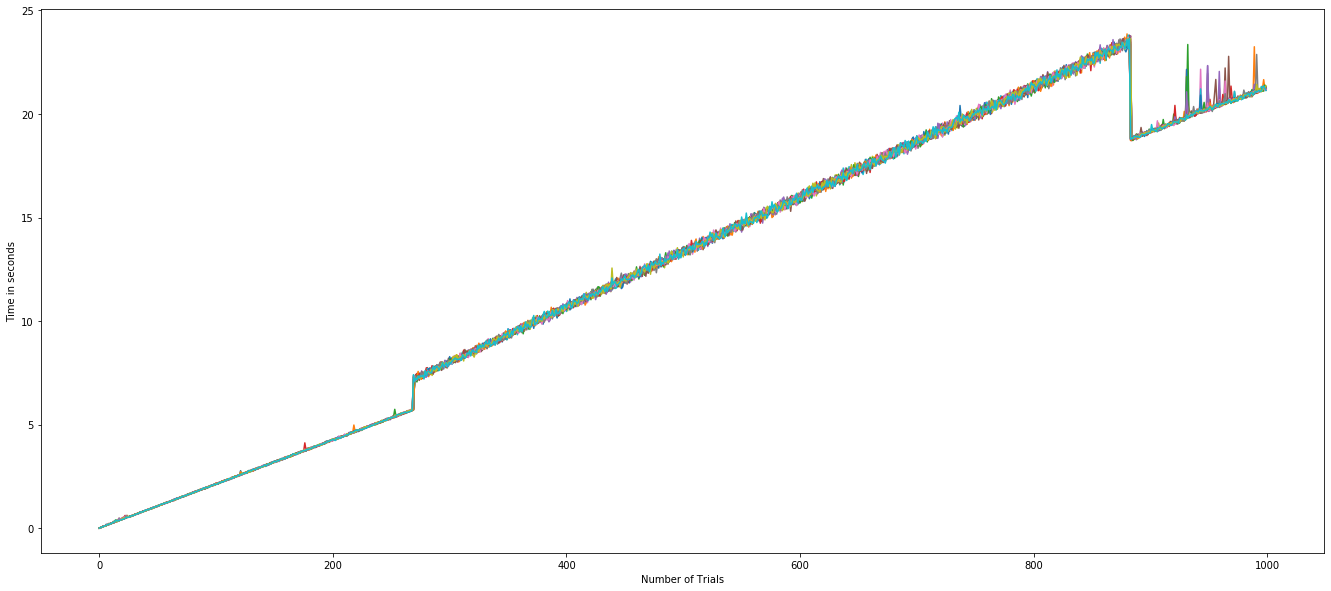

In [10]:
plt.figure(figsize=(23, 10))
get_all_lines_plot(times)
plt.show()


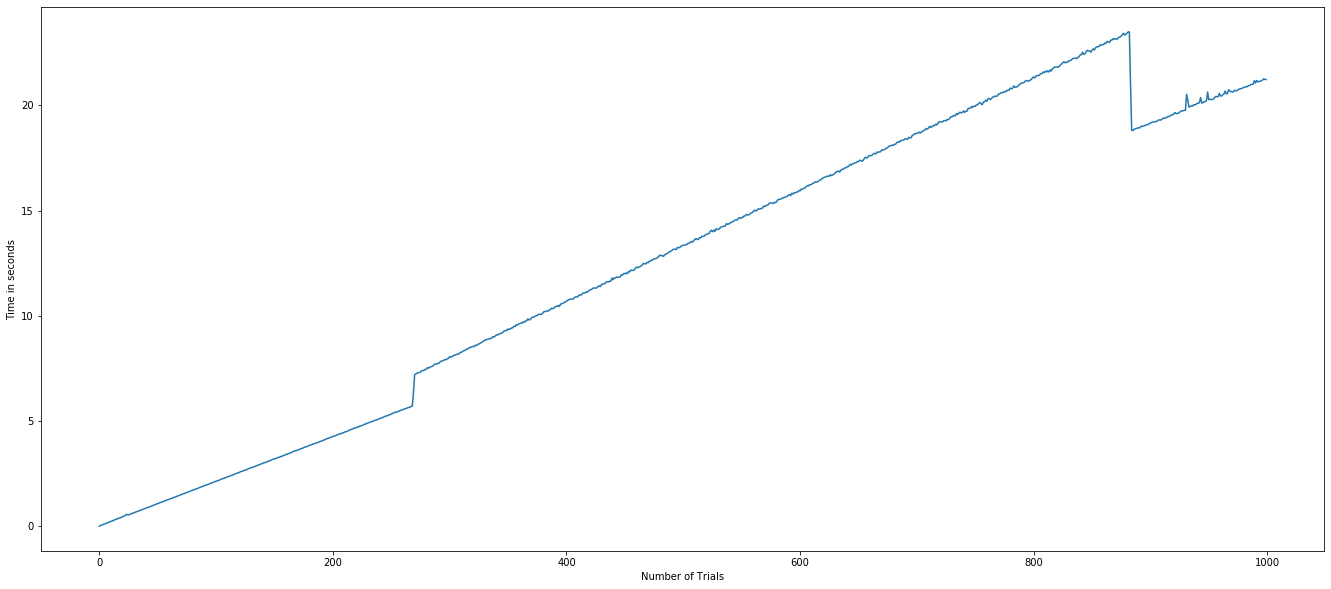

In [11]:
plt.figure(figsize=(23, 10))
get_mean_plot(times)
plt.show()


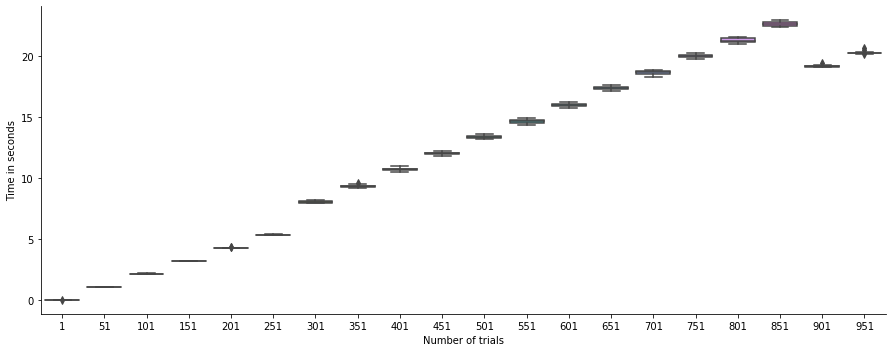

In [12]:
get_distribution_plot(times, kind="box")
plt.show()


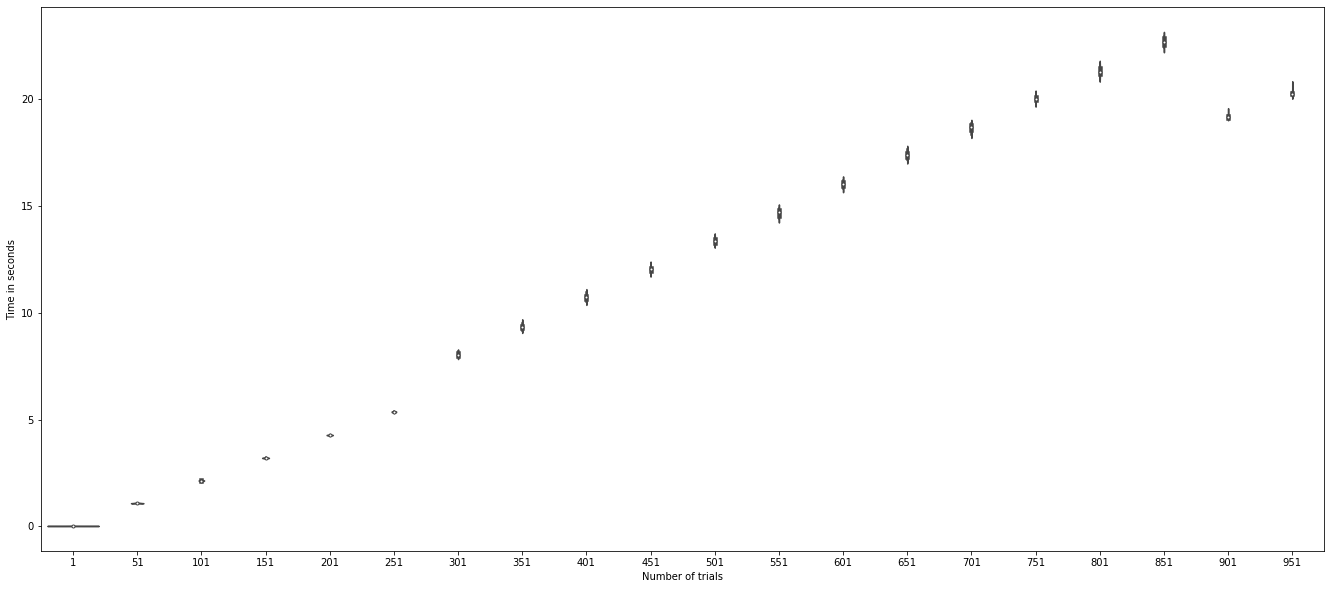

In [13]:
plt.figure(figsize=(23, 10))
get_distribution_plot(times, kind="violin")
plt.show()


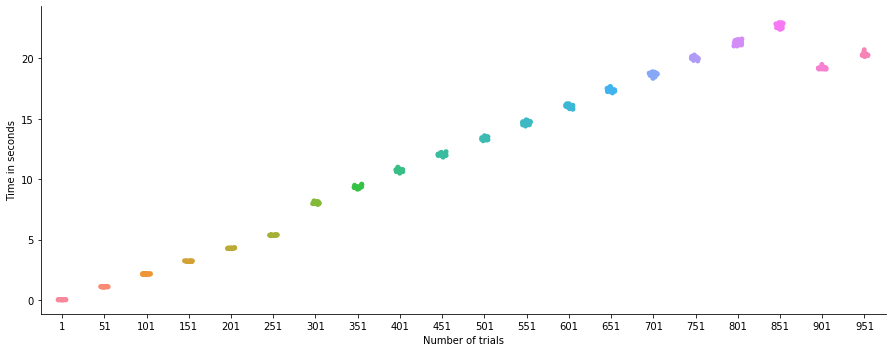

In [14]:
get_distribution_plot(times)
plt.show()


# Timing Experiment 2 - Investigate convergence of times


In [15]:
def get_multiple_runs_results(
    lambda_2, lambda_1, mu, total_capacity, threshold, num_of_trials=10
):

    warm_up_time = 100
    records = collections.namedtuple(
        "records", "waiting_times service_times blocking_times"
    )
    results = []

    for trial in range(num_of_trials):
        simulation = simulate_model(
            lambda_2, lambda_1, mu, total_capacity, threshold, random.random()
        )
        sim_results = simulation.get_all_records()

        waiting = [r.waiting_time for r in sim_results if r.arrival_date > warm_up_time]
        serving = [r.service_time for r in sim_results if r.arrival_date > warm_up_time]
        blocking = [
            r.time_blocked for r in sim_results if r.arrival_date > warm_up_time
        ]

        results.append(records(waiting, serving, blocking))

    return results


In [18]:
def results_for_different_number_of_trials(
    lambda_2, lambda_1, mu, total_capacity, threshold, num_of_trials=10
):

    results = get_multiple_runs_results(0.15, 0.2, 0.05, 8, 4, num_of_trials)

    all_waits = [w.waiting_times for w in results]
    all_services = [s.service_times for s in results]
    all_blocks = [b.blocking_times for b in results]

    return [all_waits, all_services, all_blocks]


def get_distributions_over_time(all_times):

    mean_times = []
    step = int(np.ceil(len(all_times) / 20))
    aggregated_times = [[] for _ in range(int(np.ceil(num_of_trials / step)))]
    plot_labels = []
    list_pos = 0

    for times in range(len(all_times)):
        mean_times.append(np.mean(all_times[times]))
        if times % step == 0:
            plot_labels.append(times)
            aggregated_times[list_pos] += mean_times
            list_pos += 1

    aggregated_times = aggregated_times[0:20]
    return [aggregated_times, plot_labels]


def make_plot_of_confidence_intervals(all_times, time_type=None):

    aggregated_times, plot_labels = get_distributions_over_time(all_times)
    if time_type == "w":
        title = "Mean Waiting time over number of iterations"
    elif time_type == "s":
        title = "Mean Service time over number of iterations"
    elif time_type == "b":
        title = "Mean time Blocked over number of iterations"
    else:
        title = " "

    plt.figure(figsize=(23, 10))
    plot = plt.boxplot(aggregated_times, showfliers=False, labels=plot_labels)
    plt.title(title)
    plt.xlabel("Number of trials")
    plt.ylabel("Means of times")

    return plot


In [19]:
# Queueing Parameters
lambda_2 = 0.1  # Ambulance: 6 arrivals per hour
lambda_1 = 0.05  # Others: 3 arrivals per hour
mu = 0.05  # Service time: 3 services per hour
total_capacity = 8  # Number of servers: 8 servers
threshold = 4  # Threshold of accepting ambulance patients

# Timing Parameters
num_of_trials = 10000


In [20]:
time_results = results_for_different_number_of_trials(
    lambda_2, lambda_1, mu, total_capacity, threshold, num_of_trials
)


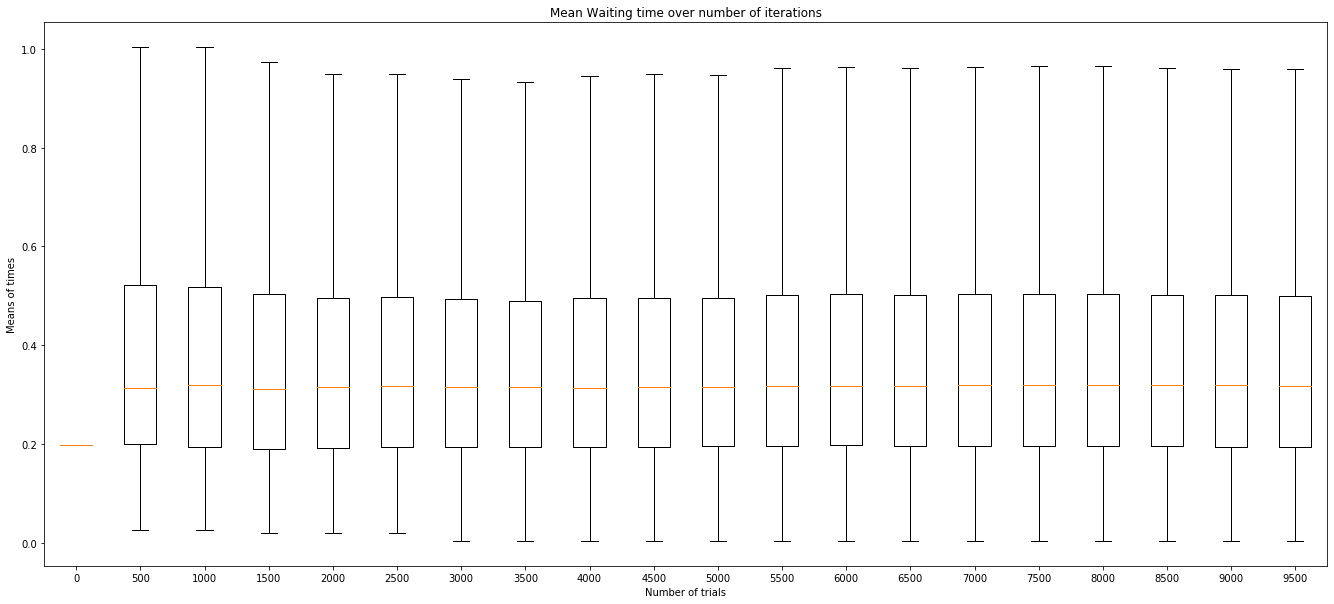

In [21]:
make_plot_of_confidence_intervals(time_results[0], time_type="w")
plt.show()


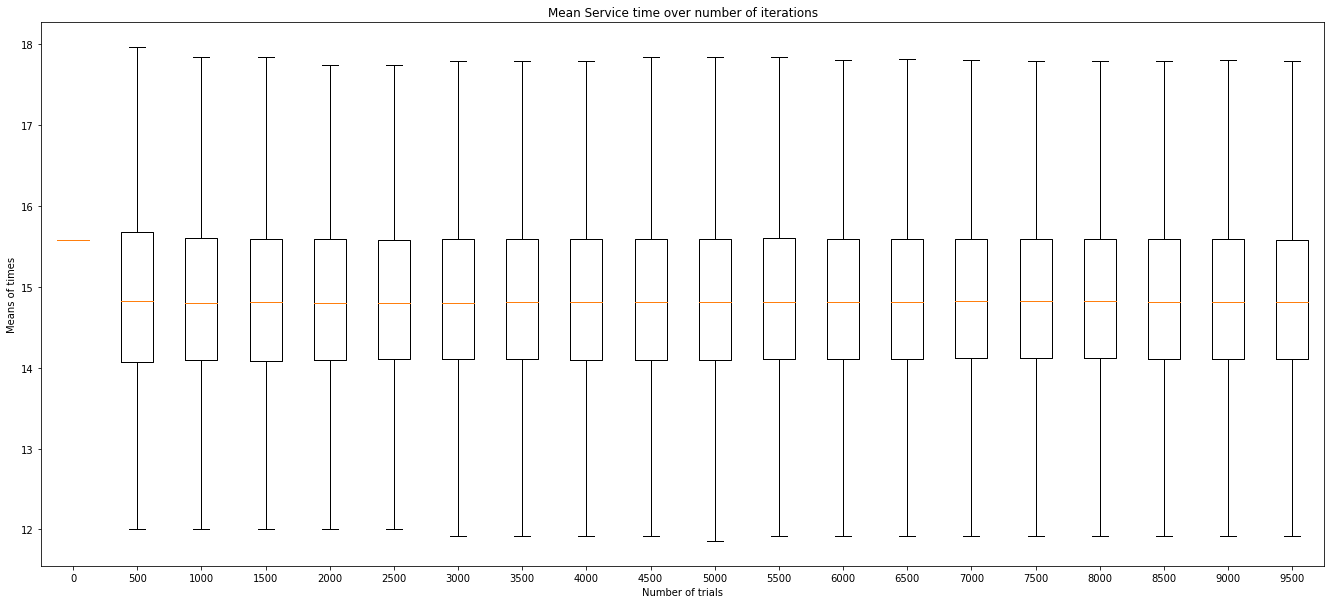

In [22]:
make_plot_of_confidence_intervals(time_results[1], time_type="s")
plt.show()


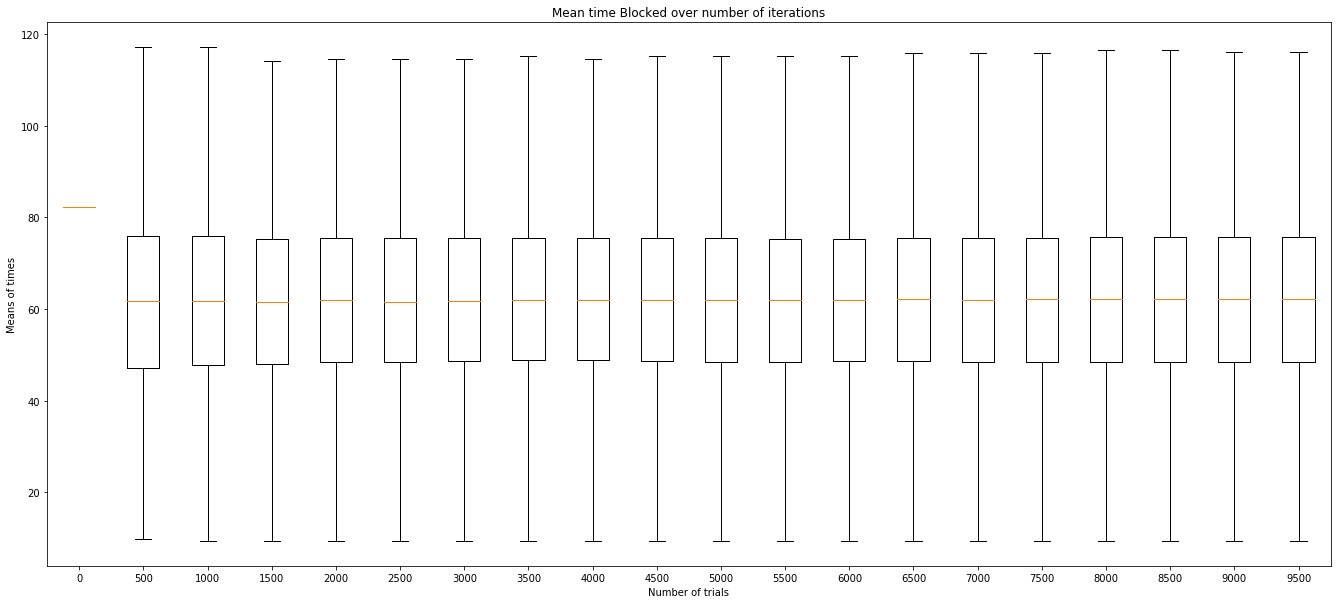

In [23]:
make_plot_of_confidence_intervals(time_results[2], time_type="b")
plt.show()


# Model plot 1 - Plots for different thresholds


In [24]:
def get_waiting_times(individuals):

    ambulance_patients_times = []
    other_patients_times = []
    patients_still_in_system = []

    for ind in individuals:
        if ind.data_records[0].node == 1 and len(ind.data_records) == 2:
            ambulance_patients_times.append(
                ind.data_records[0].waiting_time + ind.data_records[1].waiting_time
            )
        elif ind.data_records[0].node == 2 and len(ind.data_records) == 1:
            other_patients_times.append(ind.data_records[0].waiting_time)
        else:
            patients_still_in_system.append(ind)
    return [ambulance_patients_times, other_patients_times, patients_still_in_system]


def get_blocking_times(individuals):

    ambulance_patients_times = []
    other_patients_times = []
    patients_still_in_system = []

    for ind in individuals:
        if ind.data_records[0].node == 1 and len(ind.data_records) == 2:
            ambulance_patients_times.append(
                ind.data_records[0].time_blocked + ind.data_records[1].time_blocked
            )
        elif ind.data_records[0].node == 2 and len(ind.data_records) == 1:
            other_patients_times.append(ind.data_records[0].time_blocked)
        else:
            patients_still_in_system.append(ind)
    return [ambulance_patients_times, other_patients_times, patients_still_in_system]


def get_both_times(individuals):

    ambulance_patients_times = []
    other_patients_times = []
    patients_still_in_system = []

    for ind in individuals:
        if ind.data_records[0].node == 1 and len(ind.data_records) == 2:
            ambulance_patients_times.append(
                ind.data_records[0].time_blocked
                + ind.data_records[1].time_blocked
                + ind.data_records[0].waiting_time
                + ind.data_records[1].waiting_time
            )
        elif ind.data_records[0].node == 2 and len(ind.data_records) == 1:
            other_patients_times.append(
                ind.data_records[0].waiting_time + ind.data_records[0].time_blocked
            )
        else:
            patients_still_in_system.append(ind)
    return [ambulance_patients_times, other_patients_times, patients_still_in_system]


def get_times_for_patients(
    lambda_2,
    lambda_1,
    mu,
    total_capacity,
    threshold,
    seed_num=None,
    measurement_type=None,
):

    individuals = simulate_model(
        lambda_2, lambda_1, mu, total_capacity, threshold, seed_num
    ).get_all_individuals()

    if measurement_type == "w":
        times = get_waiting_times(individuals)
    elif measurement_type == "b":
        times = get_blocking_times(individuals)
    else:
        times = get_blocking_times(individuals)

    return [times[0], times[1], times[2]]


In [25]:
def make_plot_for_different_thresholds(
    lambda_2,
    lambda_1,
    mu,
    total_capacity,
    seed_num=None,
    measurement_type=None,
    plot_function=np.mean,
):
    ambulance_patients_mean_times = []
    other_patients_mean_times = []
    total_mean_times = []
    for threshold in range(total_capacity):
        times = get_times_for_patients(
            lambda_2,
            lambda_1,
            mu,
            total_capacity,
            threshold,
            seed_num,
            measurement_type,
        )
        ambulance_patients_mean_times.append(plot_function(times[0]))
        other_patients_mean_times.append(plot_function(times[1]))
        total_mean_times.append(plot_function(times[0] + times[1]))

    plt.figure(figsize=(23, 10))
    ax = plt.plot(
        ambulance_patients_mean_times,
        ":",
        other_patients_mean_times,
        ":",
        total_mean_times,
        "-",
    )

    return ax


In [26]:
# Queueing Parameters
lambda_2 = 0.1  # Ambulance: 6 arrivals per hour
lambda_1 = 0.05  # Others: 3 arrivals per hour
mu = 0.02  # Service time: 3 services per hour
total_capacity = 8  # Number of servers: 8 servers
seed_num = 2

# Plot Parameters
measurement_type = "both"  # The measurement to be plotted ["w":waiting times, "b":blocking times, otherwise: both]
plot_function = np.mean  # The function to be plotted [np.sum or np.mean]


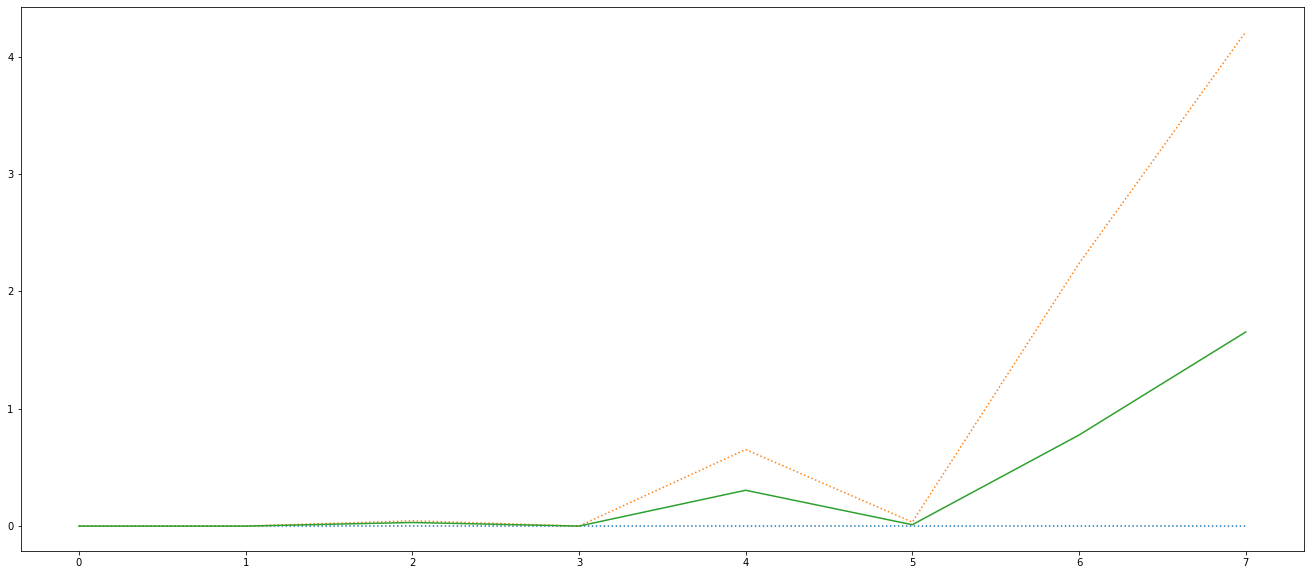

In [27]:
times = make_plot_for_different_thresholds(
    lambda_2, lambda_1, mu, total_capacity, seed_num, "w", np.mean
)
plt.show()


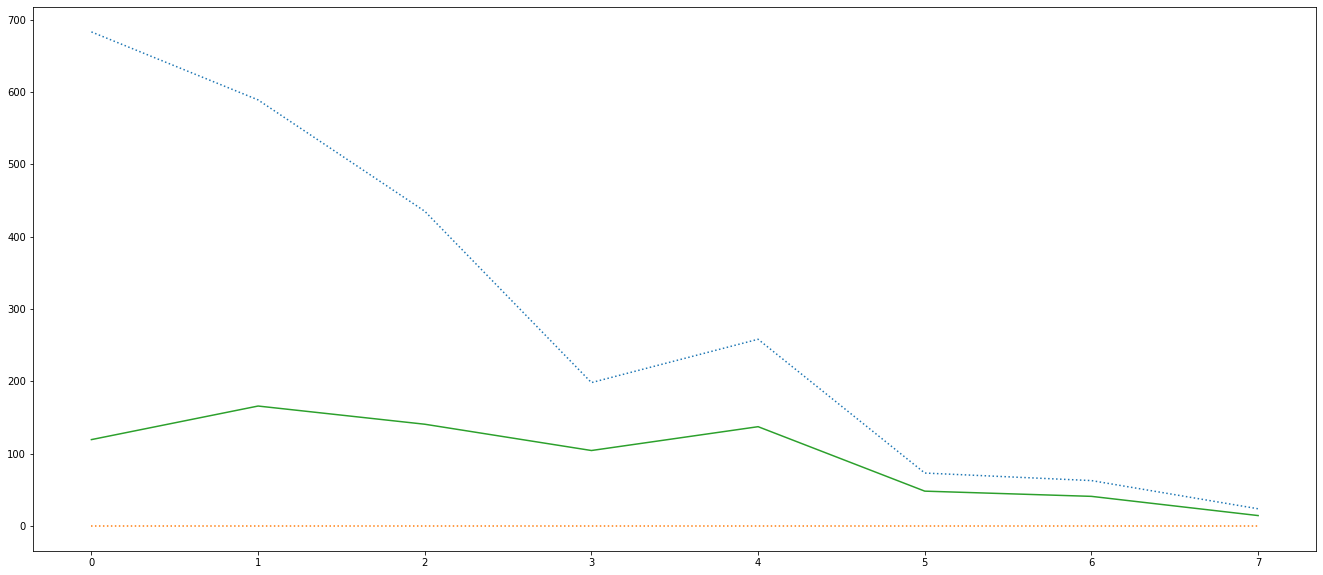

In [28]:
times = make_plot_for_different_thresholds(
    lambda_2, lambda_1, mu, total_capacity, seed_num, "b", np.mean
)
plt.show()


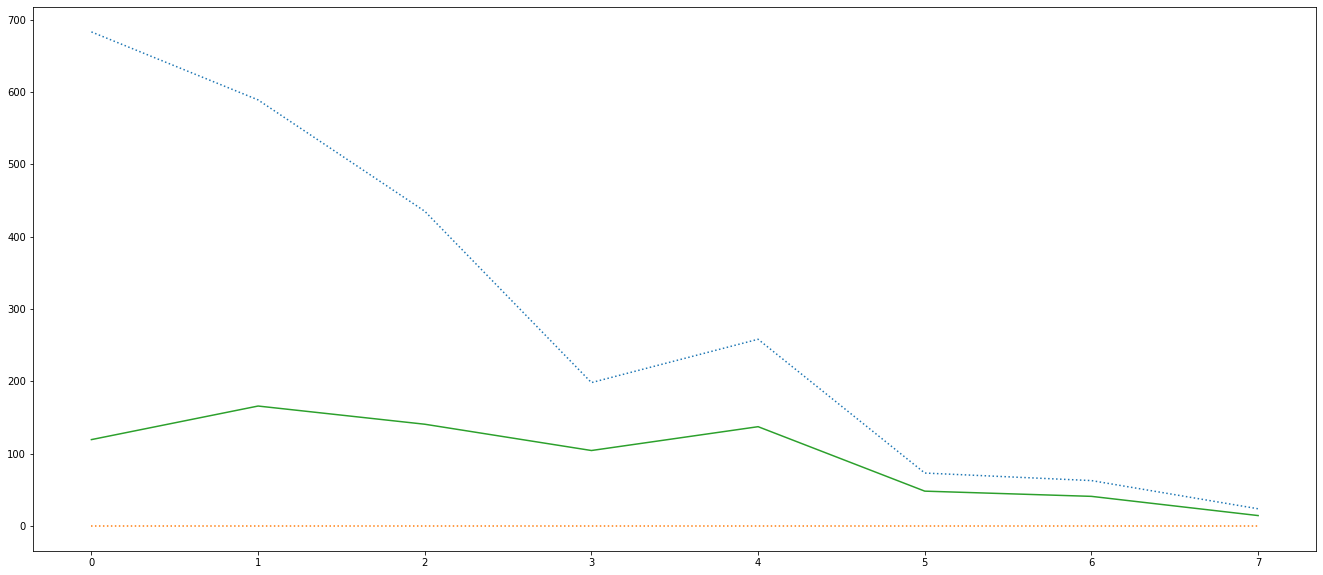

In [29]:
times = make_plot_for_different_thresholds(
    lambda_2, lambda_1, mu, total_capacity, seed_num, "both", np.mean
)
plt.show()


# Model plot 2 - Plots of proportion within time limit


In [30]:
def make_proportion_plot(lambda_2, lambda_1, mu, total_capacity, seed_num, target):
    props = []
    for threshold in range(total_capacity + 1):
        records = simulate_model(
            lambda_2, lambda_1, mu, total_capacity, threshold, seed_num
        ).get_all_records()
        waits, target_waits = 0, 0
        for rec in records:
            if rec.node == 2:
                waits += 1
                if rec.waiting_time <= target:
                    target_waits += 1
        proportion = target_waits / waits
        props.append(proportion)

    plt.figure(figsize=(23, 10))
    proportion_plot = plt.plot(props)

    return proportion_plot


In [31]:
# Queueing Parameters
lambda_2 = 0.1  # Ambulance: 6 arrivals per hour
lambda_1 = 0.08  # Others: 4.8 arrivals per hour
mu = 0.03  # Service time: 1.8 services per hour
total_capacity = 6  # Number of servers: 6 servers
seed_num = None

# Plot Parameters
target = 4


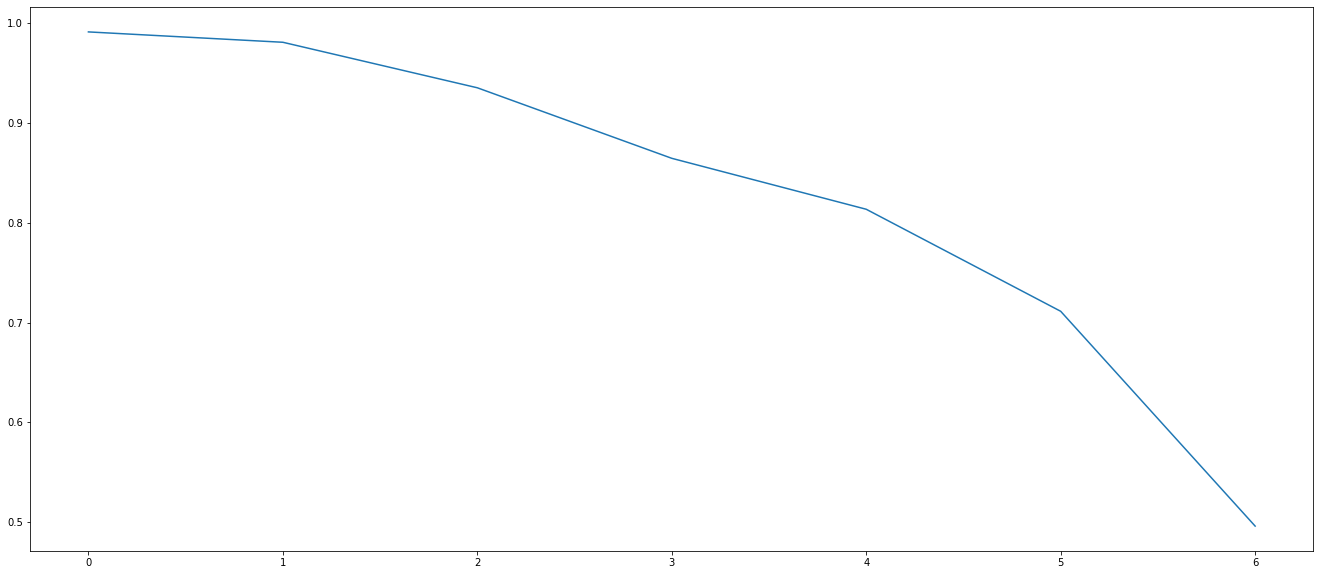

In [32]:
props = make_proportion_plot(lambda_2, lambda_1, mu, total_capacity, seed_num, target)


# Model plot 3 - Plot between two hospitals


In [33]:
def make_plot_two_hospitals_waiting(
    lambda_2,
    lambda_1_1,
    lambda_1_2,
    mu_1,
    mu_2,
    total_capacity_1,
    total_capacity_2,
    threshold_1,
    threshold_2,
    trials,
):
    step = lambda_2 / 10
    arrival_rate_1 = step
    hospital_times_1 = []
    hospital_times_2 = []
    while arrival_rate_1 < (lambda_2 - 0.0001):
        arrival_rate_2 = lambda_2 - arrival_rate_1

        times_1 = get_multiple_runs_results(
            arrival_rate_1, lambda_1_1, mu_1, total_capacity_1, threshold_1, trials
        )
        times_2 = get_multiple_runs_results(
            arrival_rate_2, lambda_1_2, mu_2, total_capacity_2, threshold_2, trials
        )

        mean_waiting_time_1 = np.mean([np.mean(w.waiting_times) for w in times_1])
        mean_waiting_time_2 = np.mean([np.mean(w.waiting_times) for w in times_2])

        hospital_times_1.append(mean_waiting_time_1)
        hospital_times_2.append(mean_waiting_time_2)

        arrival_rate_1 += step

    waiting_time_plot = plt.plot(hospital_times_1, ":", hospital_times_2, ":")

    return waiting_time_plot


In [34]:
def make_plot_two_hospitals_blocking(
    lambda_2,
    lambda_1_1,
    lambda_1_2,
    mu_1,
    mu_2,
    total_capacity_1,
    total_capacity_2,
    threshold_1,
    threshold_2,
    trials,
):
    step = lambda_2 / 10
    arrival_rate_1 = step
    hospital_times_1 = []
    hospital_times_2 = []
    while arrival_rate_1 < (lambda_2 - 0.0001):
        arrival_rate_2 = lambda_2 - arrival_rate_1

        times_1 = get_multiple_runs_results(
            arrival_rate_1, lambda_1_1, mu_1, total_capacity_1, threshold_1, trials
        )
        times_2 = get_multiple_runs_results(
            arrival_rate_2, lambda_1_2, mu_2, total_capacity_2, threshold_2, trials
        )

        mean_blocking_time_1 = np.mean([np.mean(b.blocking_times) for b in times_1])
        mean_blocking_time_2 = np.mean([np.mean(b.blocking_times) for b in times_2])

        hospital_times_1.append(mean_blocking_time_1)
        hospital_times_2.append(mean_blocking_time_2)

        arrival_rate_1 += step

    blocking_time_plot = plt.plot(hospital_times_1, ":", hospital_times_2, ":")

    return blocking_time_plot


In [35]:
lambda_2 = 0.1  # Ambulance: 6 arrivals per hour
trials = 10000

# Hospital 1 Parameters
lambda_1_1 = 0.08  # Others: 4.8 arrivals per hour
mu_1 = 0.03  # Service time: 1.8 services per hour
total_capacity_1 = 6  # Number of servers: 6 servers
threshold_1 = 4

# Hospital 2 Parameters
lambda_1_2 = 0.08
mu_2 = 0.03
total_capacity_2 = 6
threshold_2 = 4


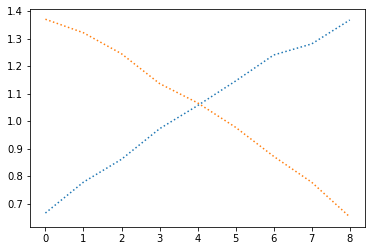

In [36]:
make_plot_two_hospitals_waiting(
    lambda_2,
    lambda_1_1,
    lambda_1_2,
    mu_1,
    mu_2,
    total_capacity_1,
    total_capacity_2,
    threshold_1,
    threshold_2,
    trials,
)
plt.show()


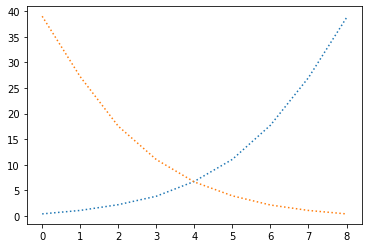

In [37]:
make_plot_two_hospitals_blocking(
    lambda_2,
    lambda_1_1,
    lambda_1_2,
    mu_1,
    mu_2,
    total_capacity_1,
    total_capacity_2,
    threshold_1,
    threshold_2,
    trials,
)
plt.show()


# Results of the model


In [127]:
# Queueing Parameters
lambda_2 = 0.1  # Ambulance: 6 arrivals per hour
lambda_1 = 0.05  # Others: 3 arrivals per hour
mu = 0.05  # Service time: 3 services per hour
total_capacity = 8  # Number of servers: 8 servers
threshold = 4  # Threshold of accepting ambulance patients


In [25]:
simulation = simulate_model(lambda_2, lambda_1, mu, total_capacity, threshold, 1)
sim_results = simulation.get_all_records()


In [26]:
# Mean Waiting Time
waits = [r.waiting_time for r in sim_results]
mean_waiting_time = sum(waits) / len(waits)
mean_waiting_time


0.009549642336239419

In [27]:
# Services in each node
service_nodes = [r.node for r in sim_results]
collections.Counter(service_nodes)


Counter({1: 152, 2: 224})

In [205]:
# Mean Time Blocked
Blocks = [r.time_blocked for r in sim_results]
mean_time_blocked = sum(Blocks) / len(Blocks)
mean_time_blocked


1.401489260432193

In [321]:
results = get_multiple_runs_results(lambda_2, lambda_1, mu, total_capacity, 4, 1)

print(np.mean([np.mean(w.waiting_times) for w in results]))
print(np.mean([np.mean(s.service_times) for s in results]))
print(np.mean([np.mean(b.blocking_times) for b in results]))


0.024603351099810346
12.099666641700496
0.6746981848352325


# Examples for testing


In [170]:
ciw.seed(5)
Q = ciw.Simulation(build_model(1, 1, 2, 1))

Q.simulate_until_max_time(100)
records = Q.get_all_records()
waits = [r.waiting_time for r in records]
blocks = [r.time_blocked for r in records]

print(len(records))
print(sum(waits))
print(sum(blocks))


290
1089.854729732795
0.0


In [171]:
ciw.seed(5)
Q = ciw.Simulation(build_model(1, 1, 2, 1), node_class=build_custom_node(7))

Q.simulate_until_max_time(100)
records = Q.get_all_records()
waits = [r.waiting_time for r in records]
blocks = [r.time_blocked for r in records]

print(len(records))
print(sum(waits))
print(sum(blocks))


290
1040.318433783405
52.00679633745028


In [172]:
sim_results = []
for i in range(10):
    simulation = simulate_model(0.15, 0.2, 0.05, 8, 4, i)
    sim_results.append(len(simulation.get_all_records()))


In [173]:
sim_results


[699, 719, 759, 715, 703, 719, 695, 685, 775, 719]

# Dummy Cells


In [631]:
# Queueing Parameters
lambda_2 = 0.1  # Ambulance: 6 arrivals per hour
lambda_1 = 0.05  # Others: 3 arrivals per hour
mu = 0.02  # Service time: 3 services per hour
total_capacity = 8  # Number of servers: 8 servers
threshold = 6  # Threshold of accepting ambulance patients


In [809]:
records = simulate_model(
    lambda_2, lambda_1, mu, total_capacity, threshold, 1
).get_all_records()
